# HomeTown Quotes Notebook

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from utils import *

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
df1 = pd.read_excel("OctBidsSeenOnce.xlsx")
df2 = pd.read_excel("NovBidsSeenOnce.xlsx", 'Sheet1')

In [4]:
df = pd.concat([df1, df2])
df.head(5)

,id,product,create_date,TheHour,TheDay,DayName,affiliate_id,affiliate_account_id,source,sub,bidamount,BidType,won_ping,consumer_ip_address,consumer_user_agent,city,state,zipcode,owns_home,months_in_residence,carrier_id,current_coverage_expiration,current_months_with_carrier,credit_type,license_valid,license_obtained_age,gender_type,marital_status_type,relationship_type,occupation,education_level,license_status,military_experience,bankruptcy,sr_22,mileage,use_type,commute_mileage,car_owned,coverage_type,comprehensive_deductible,collision_deductible,current_coverage,lead_certification_id,buyercid,NumVehicles,NumDrivers,expected_revenue,buyerid,county_name
0,3632159922,AUTO,2023-10-10 00:00:03,0,10,Tuesday,2154,14068,14990100,Organic,6.28,LEG,0,75.167.22.219,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Chandler,AZ,85249,1,12,313.0,2023-10-23,28.0,GOOD,1,16,MALE,MARRIED,SELF,OTHER,SOME_OR_NO_HIGH_SCHOOL,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,40,1,MINIMUM,50000,50000,1,D3E4C597-671D-7585-E27F-AA12EAF9433D,347.0,2,1,12.6,NaN,NaN
1,3632160078,AUTO,2023-10-10 00:00:28,0,10,Tuesday,1027,5232,Ig-8OzzwlDEYYckgQ7iq9HFV45W_qA,NaN,5.17,LEG,0,207.200.46.217,User Agent Not Available,Streator,IL,61364,0,0,313.0,2023-10-09,24.0,GOOD,1,16,MALE,MARRIED,SELF,OTHER,ASSOCIATES_DEGREE,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,VARIES,20,0,MINIMUM,10000,10000,1,1D145E0D-539B-043F-21C0-EB88A6E952BE,347.0,1,1,12.6,NaN,NaN
2,3632163844,AUTO,2023-10-10 00:11:32,0,10,Tuesday,2154,14068,14990100,Organic,5.71,LEG,0,147.219.76.110,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,Madison,WI,53719,0,12,218.0,2023-10-23,28.0,GOOD,1,16,FEMALE,SINGLE,SELF,OTHER,SOME_OR_NO_HIGH_SCHOOL,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,40,1,MINIMUM,50000,50000,1,377B06F6-B870-9B2D-62B0-BEEBD5205A19,347.0,1,1,12.6,NaN,NaN
3,3632166774,AUTO,2023-10-10 00:19:34,0,10,Tuesday,1031,14315,94eca5b76e823a5d6e7628b51510de20,NaN,5.48,LEG,1,172.58.87.221,Mozilla/5.0 (iPhone; CPU iPhone OS 16_6_1 like...,Minneapolis,MN,55412,0,24,313.0,2023-10-17,12.0,FAIR,1,18,MALE,SINGLE,SELF,OTHER,BACHELORS_DEGREE,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,15,1,STANDARD,50000,50000,1,CEB82C8D-054B-8FC6-072B-7130430815F8,347.0,2,1,12.6,NaN,NaN
4,3632167194,AUTO,2023-10-10 00:20:52,0,10,Tuesday,1031,14315,94eca5b76e823a5d6e7628b51510de20,NaN,5.79,LEG,1,108.147.101.24,Mozilla/5.0 (iPhone; CPU iPhone OS 16_7 like M...,Danville,IL,61832,0,24,313.0,2023-10-17,12.0,FAIR,1,18,FEMALE,SINGLE,SELF,OTHER,BACHELORS_DEGREE,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,15,1,STANDARD,50000,50000,1,05C01EEC-06CE-5797-A978-5CB8CC21E271,347.0,1,1,12.6,NaN,NaN


In [5]:
df.shape

(126958, 50)

## Data Exploration

### Data Cleaning

Remove unnecessary columns

product is always AUTO so we can remove it from df. Sub has many null, remove it.



In [6]:
df = df.drop(columns=['id', 'create_date', 'consumer_ip_address', 
                      'consumer_user_agent', 'lead_certification_id', 
                      'product', 'sub', 'buyercid', 'carrier_id', 'city', 'zipcode', 'current_coverage_expiration',
                      'source', 'TheDay', 'affiliate_account_id', 'BidType', 'county_name'])

For carrier, we can only remove the 145 rows with missing data.

In [7]:
numerical_columns, categorical_columns = categorize_columns(df, 'won_ping')

Numerical variables (21): ['TheHour', 'affiliate_id', 'bidamount', 'won_ping', 'owns_home', 'months_in_residence', 'current_months_with_carrier', 'license_valid', 'license_obtained_age', 'bankruptcy', 'sr_22', 'mileage', 'commute_mileage', 'car_owned', 'comprehensive_deductible', 'collision_deductible', 'current_coverage', 'NumVehicles', 'NumDrivers', 'expected_revenue', 'buyerid']
Categorical variables (12): ['DayName', 'state', 'credit_type', 'gender_type', 'marital_status_type', 'relationship_type', 'occupation', 'education_level', 'license_status', 'military_experience', 'use_type', 'coverage_type']


In [8]:
no_missing = handle_missing_data(df, categorical_columns, numerical_columns)

In [9]:
inspect_columns(no_missing)

,total_rows,rows_with_missing_values,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
TheHour,126958,0,False,24,False,0.0,0,15,23,int64
DayName,126958,0,False,7,False,0.0,Tuesday,Tuesday,Thursday,object
affiliate_id,126958,0,False,18,False,0.0,2154,1031,2262,int64
bidamount,126958,0,False,1092,False,0.0,6.28,6.94,2.99,float64
won_ping,126958,0,False,2,False,0.0,0,1,0,int64
state,126958,0,False,50,False,0.0,AZ,CO,KY,object
owns_home,126958,0,False,2,False,0.0,1,0,1,int64
months_in_residence,126958,0,False,22,False,0.0,12,12,27,int64
current_months_with_carrier,126958,0,False,56,False,0.0,28.0,0.0,0.0,float64
credit_type,126958,0,False,4,False,0.0,GOOD,FAIR,EXCELLENT,object


### One Hot Encode

In [10]:
label_columns = ['affiliate_id', 'state', 'credit_type', 'gender_type', 'marital_status_type', 'relationship_type', 'occupation', 'education_level', 'license_status', 'military_experience', 'use_type', 'coverage_type']
hot_encoded, encoder = one_hot_encode_labels(no_missing, label_columns)

In [11]:
hot_encoded.head(5)

,TheHour,DayName,bidamount,won_ping,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,expected_revenue,buyerid,affiliate_id_1031,affiliate_id_1036,affiliate_id_1043,affiliate_id_2113,affiliate_id_2116,affiliate_id_2128,affiliate_id_2154,affiliate_id_2165,affiliate_id_2238,affiliate_id_2251,affiliate_id_2254,affiliate_id_2257,affiliate_id_2258,affiliate_id_2259,affiliate_id_2261,affiliate_id_2262,affiliate_id_2263,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR
0,0,Tuesday,6.28,0,1,12,28.0,1,16,0,0,12500,40,1,50000,50000,1,2,1,12.6,76388.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,Tuesday,5.17,0,0,0,24.0,1,16,0,0,12500,20,0,10000,10000,1,1,1,12.6,76388.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0,Tuesday,5.71,0,0,12,28.0,1,16,0,0,12500,40,1,50000,50000,1,1,1,12.6,76388.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,Tuesday,5.48,1,0,24,12.0,1,18,0,0,12500,15,1,50000,50000,1,2,1,12.6,76388.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0

### Scale the numerical data

In [12]:
numerical_columns = [x for x in numerical_columns if (x != 'bidamount') and (x != 'TheHour') and (x != 'affiliate_id') and (x != 'expected_revenue')]

In [13]:
scaled, scaler = minmax_scale_data(hot_encoded, numerical_columns, feature_range=(0, 1))

In [14]:
day_numbers = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday' :4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

scaled['DayName'] = scaled['DayName'].apply(lambda x: day_numbers[x])
scaled['profit'] =  scaled['expected_revenue'] - scaled['bidamount']
scaled.head()

,TheHour,DayName,bidamount,won_ping,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,expected_revenue,buyerid,affiliate_id_1031,affiliate_id_1036,affiliate_id_1043,affiliate_id_2113,affiliate_id_2116,affiliate_id_2128,affiliate_id_2154,affiliate_id_2165,affiliate_id_2238,affiliate_id_2251,affiliate_id_2254,affiliate_id_2257,affiliate_id_2258,affiliate_id_2259,affiliate_id_2261,affiliate_id_2262,affiliate_id_2263,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR,profit
0,0,2,6.28,0.0,1.0,0.05,0.183007,0.0,0.000000,0.0,0.0,0.166667,0.222857,1.0,0.444444,0.444444,1.0,0.333333,0.0,12.6,0.898772,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,6.32
1,0,2,5.17,0.0,0.0,0.00,0.156863,0.0,0.000000,0.0,0.0,0.166667,0.108571,0.0,0.000000,0.000000,1.0,0.000000,0.0,12.6,0.898772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,7.43
2,0,2,5.71,0.0,0.0,0.05,0.183007,0.0,0.000000,0.0,0.0,0.166667,0.222857,1.0,0.444444,0.444444,1.0,0.000000,0.0,12.6,0.898772,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,6.89
3,0,2,5.48,1.0,0.0,0.10,0.078431,0.0,0.037736,0.0,0.0,0.166667,0.080000,1.0,0.44444

this shows that better to use Profit since correlated with won_ping in the better sense.

In [15]:
test = scaled[['bidamount', 'expected_revenue', 'won_ping']]
test['profit'] =  test['expected_revenue'] - test['bidamount']
test.corr()

,bidamount,expected_revenue,won_ping,profit
bidamount,1.000000,0.449568,-0.220191,-0.095833
expected_revenue,0.449568,1.000000,0.018351,0.846051
won_ping,-0.220191,0.018351,1.000000,0.151862
profit,-0.095833,0.846051,0.151862,1.000000


In [16]:
scaled[['bidamount', 'profit', 'expected_revenue', 'won_ping']].head(20)

,bidamount,profit,expected_revenue,won_ping
0,6.28,6.32,12.6,0.0
1,5.17,7.43,12.6,0.0
2,5.71,6.89,12.6,0.0
3,5.48,7.12,12.6,1.0
4,5.79,6.81,12.6,1.0
5,6.27,6.33,12.6,1.0
6,5.62,6.98,12.6,1.0
7,5.14,7.46,12.6,1.0
8,5.32,5.78,11.1,1.0
9,5.90,6.70,12.6,1.0


In [17]:
scaled.to_csv("clean_data.csv")

## Modelisation

Strategy: Now that the data is cleaned, normalized and encoded, we can apply a model.

* Since there exists no clear relationship between the bidamount and winning, we will train a regression on the bid amount only for those leads that we won.

In [48]:
scaled.shape

(126958, 133)

In [49]:
only_wins = scaled[scaled['won_ping'] == 1]
only_wins = only_wins.drop(columns=['won_ping'])
only_wins.shape

(58363, 132)

### Train - Test Split

In [51]:
X = only_wins.drop(columns='bidamount')
y = only_wins['bidamount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Regression

In [54]:
catboost_model = CatBoostRegressor(iterations=50000,  # You can adjust the number of iterations
                                   learning_rate=0.001,  # You can adjust the learning rate
                                   depth=10,  # You can adjust the depth of the trees
                                   loss_function='RMSE',  # You can choose a different loss function
                                   cat_features=[],  # Specify categorical features if any
                                   random_seed=42  # Set a random seed for reproducibility
                                   )

# Fit the model to the training data
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=500, verbose=500)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# You can also visualize feature importance if needed
feature_importances = catboost_model.get_feature_importance()
print('Feature Importances:', feature_importances[:5])

0:	learn: 1.5785515	test: 1.5809253	best: 1.5809253 (0)	total: 15.6ms	remaining: 13m
500:	learn: 1.0748284	test: 1.0753852	best: 1.0753852 (500)	total: 6.77s	remaining: 11m 8s
1000:	learn: 0.7648260	test: 0.7654237	best: 0.7654237 (1000)	total: 13.4s	remaining: 10m 57s
1500:	learn: 0.5699108	test: 0.5719799	best: 0.5719799 (1500)	total: 20.1s	remaining: 10m 48s
2000:	learn: 0.4456785	test: 0.4487230	best: 0.4487230 (2000)	total: 26.8s	remaining: 10m 41s
2500:	learn: 0.3617849	test: 0.3645577	best: 0.3645577 (2500)	total: 33.5s	remaining: 10m 35s
3000:	learn: 0.3052464	test: 0.3071834	best: 0.3071834 (3000)	total: 40.2s	remaining: 10m 30s
3500:	learn: 0.2648479	test: 0.2662265	best: 0.2662265 (3500)	total: 47.1s	remaining: 10m 25s
4000:	learn: 0.2336004	test: 0.2351104	best: 0.2351104 (4000)	total: 54s	remaining: 10m 20s
4500:	learn: 0.2100413	test: 0.2119765	best: 0.2119765 (4500)	total: 1m	remaining: 10m 16s
5000:	learn: 0.1920436	test: 0.1944341	best: 0.1944341 (5000)	total: 1m 7s	re

Now, we have a model that learned the bid amount for leads that we won. Let's apply this model to test data for leads that we won and on leads that we lost.

In [55]:
X_test['bidamount'] = y_test
X_test['bidamount_predicted'] = y_pred
X_test['won_ping'] = 1

In [56]:
X_test.head()

,TheHour,DayName,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,expected_revenue,buyerid,affiliate_id_1031,affiliate_id_1036,affiliate_id_1043,affiliate_id_2113,affiliate_id_2116,affiliate_id_2128,affiliate_id_2154,affiliate_id_2165,affiliate_id_2238,affiliate_id_2251,affiliate_id_2254,affiliate_id_2257,affiliate_id_2258,affiliate_id_2259,affiliate_id_2261,affiliate_id_2262,affiliate_id_2263,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR,profit,bidamount,bidamount_predicted,won_ping
67644,8,4,1.0,0.1,0.078431,0.0,0.037736,0.0,0.0,0.166667,0.08,1.0,0.444444,0.444444,1.0,0.333333,0.000000,17.39,0.500332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,12.96,4.43,4.458434,1
11394,8,1,0.0,0.1,0.078431,0.0,0.037736,0.0,0.0,0.166667,0.08,1.0,0.444444,0.444444,1.0,0.000000,0.000000,12.60,0.898772,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,7.04,5.56,5.559196,1
94545,11,7,1.0,0.1,0.078431,0.0,0.037736,0.0,0.0,0.166667,0.08,1.0,0.444444,0.444444,1.0,0.333333,0.333333,11.42,0.991004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,8.70,2.72,2.716780,1
28254,9,4,0.0,0.1,0.07843

Do the same on leads that we lost.

In [57]:
X_test_lost = scaled[scaled['won_ping'] == 0].sample(X_test.shape[0])
y_test_lost = X_test_lost['bidamount']
X_test_lost.drop(columns=['won_ping', 'bidamount'])

y_pred_lost = catboost_model.predict(X_test_lost)

X_test_lost['bidamount'] = y_test_lost
X_test_lost['bidamount_predicted'] = y_pred_lost
X_test_lost['won_ping'] = 0

In [58]:
X_test_lost.head()

,TheHour,DayName,bidamount,won_ping,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,expected_revenue,buyerid,affiliate_id_1031,affiliate_id_1036,affiliate_id_1043,affiliate_id_2113,affiliate_id_2116,affiliate_id_2128,affiliate_id_2154,affiliate_id_2165,affiliate_id_2238,affiliate_id_2251,affiliate_id_2254,affiliate_id_2257,affiliate_id_2258,affiliate_id_2259,affiliate_id_2261,affiliate_id_2262,affiliate_id_2263,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR,profit,bidamount_predicted
69558,15,4,6.94,0,1.0,0.100000,0.156863,0.0,0.0,0.0,0.0,0.166667,0.274286,1.0,0.000000,0.000000,1.0,0.0,0.0,12.6,0.866841,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.66,6.955404
34530,12,1,7.25,0,1.0,0.100000,0.156863,0.0,0.0,0.0,0.0,0.166667,0.274286,1.0,0.000000,0.000000,1.0,0.0,0.0,12.6,0.898772,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.35,7.259474
34876,15,1,6.92,0,1.0,0.050000,0.313725,0.0,0.0,0.0,0.0,0.222222,0.314286,0.0,0.444444,0.444444,1.0,0.0,0.0,12.6,0.898772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.68,6.890788
44329,9,7,2.01,0,1.0,0.104167,0.163399,0.0,0.

Union the two test data.

In [130]:
concatenated_test = pd.concat([X_test, X_test_lost])

Check the difference between the bid amount and the prediction from the model and compute the probability.

In [96]:
concatenated_test['abs_diff'] = abs(concatenated_test['bidamount_predicted'] - concatenated_test['bidamount'])
concatenated_test['diff'] = concatenated_test['bidamount'] - concatenated_test['bidamount_predicted']
concatenated_test['diff_percentage'] = (concatenated_test['bidamount'] - concatenated_test['bidamount_predicted']) / (concatenated_test['bidamount_predicted'])
concatenated_test['rounded_diff_percentage'] = round((concatenated_test['bidamount'] - concatenated_test['bidamount_predicted']) / (concatenated_test['bidamount_predicted']), 1)
concatenated_test['custom_rounded_diff_percentage'] = ((concatenated_test['bidamount'] - concatenated_test['bidamount_predicted']) / (concatenated_test['bidamount_predicted'])) // 0.5

concatenated_test['rounded_diff'] = round(concatenated_test['diff'], 0)

In [97]:
concatenated_test.head(5)

,TheHour,DayName,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,expected_revenue,buyerid,affiliate_id_1031,affiliate_id_1036,affiliate_id_1043,affiliate_id_2113,affiliate_id_2116,affiliate_id_2128,affiliate_id_2154,affiliate_id_2165,affiliate_id_2238,affiliate_id_2251,affiliate_id_2254,affiliate_id_2257,affiliate_id_2258,affiliate_id_2259,affiliate_id_2261,affiliate_id_2262,affiliate_id_2263,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR,profit,bidamount,bidamount_predicted,won_ping,abs_diff,diff,diff_percentage,rounded_diff_percentage,custom_rounded_diff_percentage,rounded_diff
67644,8,4,1.0,0.1,0.078431,0.0,0.037736,0.0,0.0,0.166667,0.08,1.0,0.444444,0.444444,1.0,0.333333,0.000000,17.39,0.500332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,12.96,4.43,4.458434,1,0.028434,-0.028434,-0.006378,-0.0,-1.0,-0.0
11394,8,1,0.0,0.1,0.078431,0.0,0.037736,0.0,0.0,0.166667,0.08,1.0,0.444444,0.444444,1.0,0.000000,0.000000,12.60,0.898772,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,7.04,5.56,5.559196,1,0.000804,0.000804,0.000145,0.0,0.0,0.0
94545,11,7,1.0,0.1,0.078431,0.0,0.037736,0.0,0.0,0.166667,0.08,1.0,0.444444,0.444444,1.0,0.333333,0.333333,11.42,0.991004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0

<Axes: xlabel='diff', ylabel='Count'>

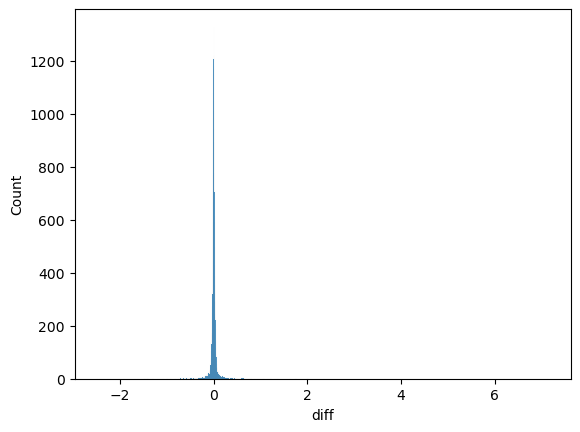

In [116]:
sns.histplot(x='diff', data=concatenated_test)

In [117]:
test = concatenated_test.groupby('rounded_diff')[['won_ping']].agg(lambda x: x.sum() / x.count())

In [118]:
test = test.reset_index()

In [119]:
test

,rounded_diff,won_ping
0,-2.0,0.727273
1,-1.0,0.206349
2,-0.0,0.500129
3,1.0,0.666667
4,2.0,0.833333
5,4.0,0.500000
6,6.0,1.000000
7,7.0,0.000000


Plot to show

<Axes: xlabel='rounded_diff', ylabel='won_ping'>

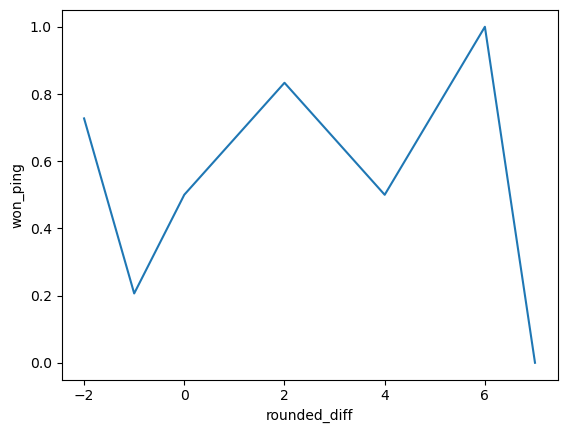

In [120]:
sns.lineplot(x='rounded_diff', y='won_ping', data=test)

What happens when we look with percentage?

In [121]:
test = concatenated_test.groupby('rounded_diff_percentage')[['won_ping']].agg(lambda x: x.sum() / x.count())

In [122]:
test

,won_ping
rounded_diff_percentage,
-0.9,0.000000
-0.8,0.000000
-0.7,0.000000
-0.6,0.000000
-0.5,0.400000
-0.4,0.454545
-0.3,0.500000
-0.2,0.313433
-0.1,0.448692


<Axes: xlabel='rounded_diff_percentage', ylabel='won_ping'>

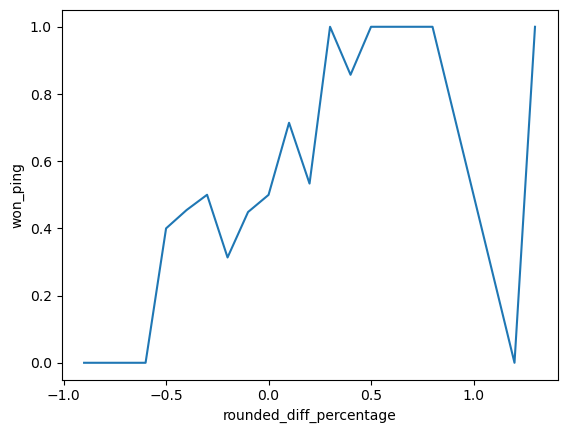

In [123]:
sns.lineplot(x='rounded_diff_percentage', y='won_ping', data=test)

In [124]:
df.groupby('won_ping')[['TheHour']].count()

,TheHour
won_ping,
0,68595
1,58363


In [125]:
df.groupby('won_ping')[['bidamount']].mean()

,bidamount
won_ping,
0,5.475789
1,4.722001


In [126]:
concatenated_test.groupby('won_ping')[['bidamount']].mean()

,bidamount
won_ping,
0,5.472151
1,4.732220


In [127]:
concatenated_test.groupby('won_ping')[['bidamount_predicted']].mean()

,bidamount_predicted
won_ping,
0,5.478181
1,4.730758


<Axes: xlabel='won_ping', ylabel='diff'>

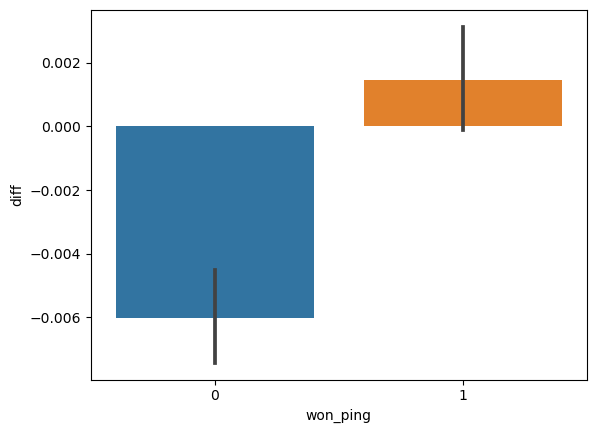

In [128]:
sns.barplot(x='won_ping', y='diff', data=concatenated_test)